**IST597 Assignment:- Build your own custom optimizer:- pgb5080@psu.edu**

In [1]:
# Load Library
import os
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from math import sqrt
np.random.seed(5080*7)
tf.random.set_seed(5080*7)

In [2]:
# # Load Data
fmnist = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# Split Data

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

(X_train, y_train), (X_test, y_test) = fmnist

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=(1-train_ratio))
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=((test_ratio/(validation_ratio+test_ratio))))

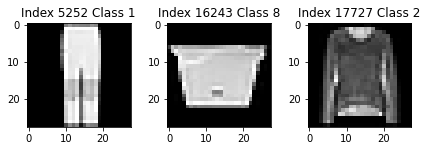

In [4]:
# Display Sample Data

indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [5]:
# Print Size
print("X_train Size:" + str(X_train.shape))
print("X_val Size:" + str(X_val.shape))
print("X_test Size:" + str(X_test.shape))

print("y_train Size:" + str(y_train.shape))
print("y_val Size:" + str(y_val.shape))
print("y_test Size:" + str(y_test.shape))

X_train Size:(56000, 28, 28)
X_val Size:(7000, 28, 28)
X_test Size:(7000, 28, 28)
y_train Size:(56000,)
y_val Size:(7000,)
y_test Size:(7000,)


In [6]:
# Reshape Input Data
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1]*X_val.shape[2]))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

print("X_train Size:" + str(X_train.shape))
print("X_val Size:" + str(X_val.shape))
print("X_test Size:" + str(X_test.shape))

X_train Size:(56000, 784)
X_val Size:(7000, 784)
X_test Size:(7000, 784)


In [7]:
# Rescale data 
X_train=tf.cast(X_train,dtype=tf.float32)
X_val=tf.cast(X_val,dtype=tf.float32)
X_test=tf.cast(X_test,dtype=tf.float32)
X_train=X_train/255.0
X_val=X_val/255.0
X_test=X_test/255.0

In [8]:
# Details of input & output data

print("Training input data range: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))
print("Validation input data range: \nFrom " + str(np.min(X_val)) + " to " + str(np.max(X_val)))
print("Testing input data range: \nFrom " + str(np.min(X_test)) + " to " + str(np.max(X_test)))

print("\nTraining target data: ")
print(set(list(y_train)))

print("\nValidation target data: ")
print(set(list(y_val)))

print("\nTesting target data: ")
print(set(list(y_test)))

Training input data range: 
From 0.0 to 1.0
Validation input data range: 
From 0.0 to 1.0
Testing input data range: 
From 0.0 to 1.0

Training target data: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Validation target data: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Testing target data: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [9]:
# Split Data
size_input = X_train.shape[1] # Input size
Input_layer_size =  128 # Input size
size_hidden1 = 128 # Hidden neuron in first layer
size_hidden2 = 128 # Hidden neuron in second layer
size_output = 10 # Number of classes (target)

y_train=tf.keras.utils.to_categorical(y_train,size_output)
y_val=tf.keras.utils.to_categorical(y_val,size_output)
y_test=tf.keras.utils.to_categorical(y_test,size_output)

In [10]:
# Print 
print("y_train: ",y_train)
print("y_val: ",y_val)
print("y_test: ",y_test)

y_train:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
y_val:  [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y_test:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [11]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
print("train_ds:",train_ds)
print("train_ds:",val_ds)
print("test_ds:",test_ds)

train_ds: <BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
train_ds: <BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
test_ds: <BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


## Build MLP using Eager Execution & custom optimizer

In [12]:
# Define class to build mlp model
class MLP(object):
  def __init__(self,size_input,Input_layer_size,size_hidden1,size_hidden2,size_output,device):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.Input_layer_size, self.size_hidden1, self.size_hidden2, self.size_output, self.device=\
    size_input, Input_layer_size, size_hidden1, size_hidden2, size_output, device
    
    # Initialize weights for input
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.Input_layer_size],stddev=0.1))
    # Initialize biases for input layer
    self.b1 = tf.Variable(tf.zeros([1, self.Input_layer_size]))
     # Initialize weights between input layer and first hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.Input_layer_size, self.size_hidden1],stddev=0.1))
    # Initialize biases for first hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden1]))
     # Initialize weights between first hidden layer and second hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for second hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    # Initialize weights between second hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    return loss_x

  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
 
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    #Compute values in input layer
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)    
    # Compute values in first hidden layer
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute values in second hidden layer
    what3 = tf.matmul(hhat2, self.W3) + self.b3
    hhat3 = tf.nn.relu(what3)
    # Compute output
    output = tf.matmul(hhat3, self.W4) + self.b4
    # return tf.nn.softmax(output)
    return output

     # Calculate standard error
  def stderr(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    std_err = std_dev/sqrt(len(y_pred_tf))
    return std_err 

     # Calculate variance error
  def var(self,y_pred):
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    std_dev = np.std(y_pred_tf) #Calculates standard deviation
    variance = (std_dev**2) # calculate variance
    return variance 

## Train Model:


Train Accuracy: 0.8307
Number of Epoch = 1 - Average Cross Entropy:= 0.0052164066859654015 

Validation Accuracy: 0.8327

Train Accuracy: 0.8505
Number of Epoch = 2 - Average Cross Entropy:= 0.003559558868408203 

Validation Accuracy: 0.8497

Train Accuracy: 0.8597
Number of Epoch = 3 - Average Cross Entropy:= 0.0032385937826974053 

Validation Accuracy: 0.8569

Train Accuracy: 0.8666
Number of Epoch = 4 - Average Cross Entropy:= 0.0030701966966901507 

Validation Accuracy: 0.8611

Train Accuracy: 0.8717
Number of Epoch = 5 - Average Cross Entropy:= 0.0029447732652936663 

Validation Accuracy: 0.8664

Train Accuracy: 0.8706
Number of Epoch = 6 - Average Cross Entropy:= 0.0028736201695033483 

Validation Accuracy: 0.8653

Train Accuracy: 0.8778
Number of Epoch = 7 - Average Cross Entropy:= 0.0028231825147356305 

Validation Accuracy: 0.8703

Train Accuracy: 0.8777
Number of Epoch = 8 - Average Cross Entropy:= 0.002793686730521066 

Validation Accuracy: 0.8744

Train Accuracy: 0.8745
Nu

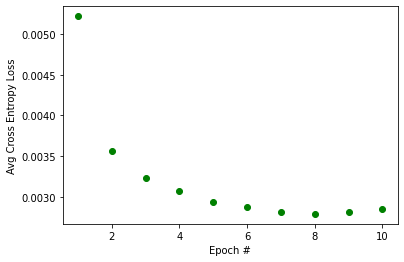

In [13]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model using CPU
mlp_on_cpu = MLP(size_input,Input_layer_size,size_hidden1,size_hidden2,size_output,device='none')

time_start = time.time()

for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5080)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')
  plt.xlabel('Epoch #')
  plt.ylabel('Avg Cross Entropy Loss')
        
time_taken = time.time() - time_start
    
# Validate model
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

## One Step Inference: Testing

In [14]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  standard_error = mlp_on_cpu.stderr(preds) # Standard error
  Variance = mlp_on_cpu.var(preds) # Variance
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

# Print
print('Test standard error: {:.4f}'.format(standard_error))
print('Test variance: {:.4f}'.format(Variance))

Test loss: 0.0989

Test Accuracy: 0.87
Test standard error: 8.0873
Test variance: 261.6198
